<a href="https://colab.research.google.com/github/Davidsonity/Dog_Breed/blob/main/Dog_Breed_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Dog Breed Prediction**

In [ ]:
# Select the kaggle.json file downloaded frm kaggle account settting page
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"vokeeshemitan","key":"2ab08ee83981b7004451cc7bd4b43d73"}'}

In [ ]:
# Installing Kaggle API client
!pip install -q kaggle

In [ ]:
# creating /.kaggle because the kaggle API client expect the file to be in this format so we move it there
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# This permissons changes avoid a warning on kaggle tool startup
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Creating directory and changing the current working directory
!mkdir dog_dataset
%cd dog_dataset

/content/dog_dataset


In [ ]:
# search for dataset
!kaggle competitions download -c dog-breed-identification

 99% 682M/691M [00:04<00:00, 175MB/s]
100% 691M/691M [00:04<00:00, 149MB/s]


In [ ]:
# unzipping downloaded dataset
!unzip dog-breed-identification.zip
!rm dog-breed-identification.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/83bc62b0fffa99a9c94ba0b67a5f7395.jpg  
  inflating: train/83bcff6b55ee179a7c123fa6103c377a.jpg  
  inflating: train/83be6d622ab74a5e7e08b53eb8fd566a.jpg  
  inflating: train/83c2d7419b0429b9fe953bc1b6cddbec.jpg  
  inflating: train/83cf7d7cd2a759a93e2ffd95bea9c6fb.jpg  
  inflating: train/83d405858f0931722ef21e8ac0adee4d.jpg  
  inflating: train/83d4125a4c3c7dc5956563276cb1cd74.jpg  
  inflating: train/83f0bb565b2186dbcc6a9d009cb26ff2.jpg  
  inflating: train/83fad0718581a696132c96c166472627.jpg  
  inflating: train/83fbbcc9a612e3f712b1ba199da61f20.jpg  
  inflating: train/8403d8936430c2f05ab7d74d23c2c0cb.jpg  
  inflating: train/8406d837b2d7fac1c3cd621abb4c4f9e.jpg  
  inflating: train/840b67d26e5e43f8eb6430f62d4ba1ac.jpg  
  inflating: train/840db91ba4600148f3dcb06ec419b421.jpg  
  inflating: train/840dbad5a691c22611d85b2488bf4cbb.jpg  
  inflating: train/8410ced9ebc1759a7ebce5c42bfb5222.jpg  
  inflating: train/84

In [ ]:
# Important library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from keras.preprocessing import image
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.applications.xception import Xception as PretrainedModel

In [ ]:
# Reading the labels.csv file and checking shape and records
labels = pd.read_csv('labels.csv')
print(labels.shape)
labels.head()

(10222, 2)


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [ ]:
# Get the number of each breed
breed_all = labels['breed']
breed_counts = breed_all.value_counts()
breed_counts.head()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
Name: breed, dtype: int64

In [ ]:
classname = breed_counts.index.tolist()[:10]
print(classname)

['scottish_deerhound', 'maltese_dog', 'afghan_hound', 'entlebucher', 'bernese_mountain_dog', 'shih-tzu', 'great_pyrenees', 'pomeranian', 'basenji', 'samoyed']


In [ ]:
labels = labels[(labels['breed'].isin(classname))]
labels = labels.reset_index(drop= True)
labels.head()

,id,breed
0,003df8b8a8b05244b1d920bb6cf451f9,basenji
1,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound
2,00693b8bc2470375cc744a6391d397ec,maltese_dog
3,0162b3e0144fb1d1ab82fbff3ace9938,shih-tzu
4,01b36cb1b80ab8c3a7d2b7128ad21bdc,samoyed


In [ ]:
# Creating numpy matrix with zeros
X_data = np.zeros((len(labels), 224,224,3), dtype = 'float32')
# One hot encoding
Y_data = label_binarize(labels['breed'], classes=classname)

#Reading and converting image to numpy array and normalizing dataset
for i in tqdm(range(len(labels))):
  img = image.load_img('train/%s.jpg' % labels['id'][i], target_size=(224,224))
  img = image.img_to_array(img)
  X = np.expand_dims(img.copy(),axis = 0)
  X_data[i] = X/255.0

#printing train image and onehot encode shape & size
print('\nX Shape:', X_data.shape, 'size: {:,}'.format(X_data.size))
print('Y Shape:', Y_data.shape, 'size: {:,}'.format(Y_data.size))

100%|██████████| 1141/1141 [00:03<00:00, 291.33it/s]


X Shape: (1141, 224, 224, 3) size: 171,752,448
Y Shape: (1141, 10) size: 11,410


In [ ]:
#Splitting the data set onto training and testing datasets
X_train_and_val, X_test, Y_train_and_val, Y_test = train_test_split(X_data, Y_data, test_size=0.1)
#Splitting the training data set into training and validation datasets
X_train, X_val, Y_train, Y_val = train_test_split(X_train_and_val, Y_train_and_val, test_size= 0.2)

In [ ]:
k = len(classname)
print('number of classes:', k)

number of classes: 10


In [ ]:
# Building the Model
ptm = PretrainedModel(
    input_shape= X_data[0].shape,
    weights = 'imagenet',
    include_top = False
)
# Freeze pretrained model weights
ptm.trainable = False

# map date
x = Flatten()(ptm.output)
x = Dense(k, activation='softmax')(x)

model = Model(inputs = ptm.input, outputs = x)

model.compile(optimizer= Adam(0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

83697664/83683744 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                      

In [ ]:
batch_size = 128
steps_per_epoch = X_train.shape[0]//batch_size
r = model.fit(X_train, Y_train, batch_size = batch_size,
              epochs = 10,
              validation_data = (X_val, Y_val),
              steps_per_epoch = steps_per_epoch)

Epoch 1/10
6/6 [==============================] - 22s 1s/step - loss: 0.9866 - accuracy: 0.6979 - val_loss: 0.1621 - val_accuracy: 0.9660
Epoch 2/10
6/6 [==============================] - 5s 639ms/step - loss: 0.1337 - accuracy: 0.9581 - val_loss: 0.1225 - val_accuracy: 0.9660
Epoch 3/10
6/6 [==============================] - 3s 587ms/step - loss: 0.0698 - accuracy: 0.9754 - val_loss: 0.1065 - val_accuracy: 0.9563
Epoch 4/10
6/6 [==============================] - 3s 588ms/step - loss: 0.0480 - accuracy: 0.9841 - val_loss: 0.1091 - val_accuracy: 0.9612
Epoch 5/10
6/6 [==============================] - 3s 591ms/step - loss: 0.0377 - accuracy: 0.9899 - val_loss: 0.1172 - val_accuracy: 0.9660
Epoch 6/10
6/6 [==============================] - 3s 582ms/step - loss: 0.0221 - accuracy: 0.9942 - val_loss: 0.1298 - val_accuracy: 0.9563
Epoch 7/10
6/6 [==============================] - 3s 590ms/step - loss: 0.0128 - accuracy: 0.9986 - val_loss: 0.1303 - val_accuracy: 0.9612
Epoch 8/10
6/6 [======

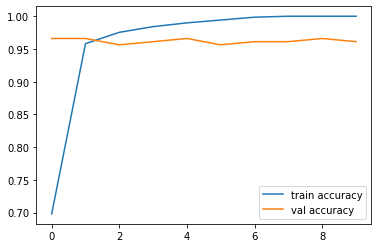

In [ ]:
# Plot accouracy per iteration
plt.plot(r.history['accuracy'], label= 'train accuracy')
plt.plot(r.history['val_accuracy'], label= 'val accuracy')
plt.legend()
plt.show()

In [ ]:
# Using test set and finding accuracy
Y_pred = model.predict(X_test)
score = model.evaluate(X_test,Y_test)
print('Accuracy of over the test set: \n', score[1] * 100, '%')

4/4 [==============================] - 0s 105ms/step - loss: 0.1088 - accuracy: 0.9565
Accuracy of over the test set: 
 95.652174949646 %


In [ ]:
# Saving Model
model.save('dog_breed.h5')

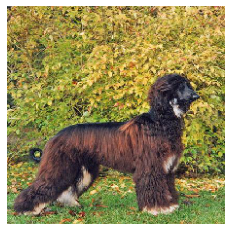

Originally:  afghan_hound
Predicted:  afghan_hound


In [ ]:
# Plotting image to compare
plt.imshow(X_test[1,:,:,:])
plt.axis('off')
plt.show()

# Finding max value from prediction list and comparing original value vs predicted
print("Originally: ", classname[np.argmax(Y_test[1])])
print("Predicted: ", classname[np.argmax(Y_pred[1])])

In [ ]:
import cv2
from keras.models import load_model

In [ ]:
# loading the model
model = load_model('dog_breed.h5')

In [ ]:
Y_pred = model.predict(X_test)
score = model.evaluate(X_test,Y_test)
print('Accuracy of over the test set: \n', score[1] * 100, '%')

4/4 [==============================] - 1s 105ms/step - loss: 0.1088 - accuracy: 0.9565
Accuracy of over the test set: 
 95.652174949646 %


In [ ]:
img = cv2.imread('/content/Scottich_deerhound.jpg', -1)
opencv_image = cv2.resize(img, (224, 224))
opencv_image = image.img_to_array(opencv_image)
opencv_image = np.expand_dims(opencv_image.copy(),axis = 0)
opencv_image = opencv_image/255.0

In [ ]:
opencv_image.shape

(1, 224, 224, 3)

In [ ]:
prediction = model.predict(opencv_image)

In [ ]:
classname[np.argmax(prediction)]

'scottish_deerhound'

### The End!!